In [160]:
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# ====================================================
# 1. Base Dataset Definition (One Day per Sample)
# ====================================================
class WaterQualityDataset(Dataset):
    def __init__(self, mat_file, train=True, transform=None):
        """
        Args:
            mat_file (str): Path to the .mat file containing the dataset.
            train (bool): If True, load training data; otherwise load test data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        data = scipy.io.loadmat(mat_file)
        self.transform = transform

        # Process location group information
        location_group = data['location_group']  # shape: (1, 3)
        location_ids = data['location_ids'].flatten()  # shape: (37,)
        num_stations = len(location_ids)  # should be 37

        # Create an array to store the group ID for each station
        group_ids = np.zeros(num_stations, dtype=np.float32)
        for i in range(location_group.shape[1]):
            station_indices = location_group[0, i].flatten() - 1  # convert to 0-indexed
            group_ids[station_indices] = i + 1  # assign group number (1, 2, 3)
        self.group_ids = group_ids

        # Load training or testing data based on flag
        if train:
            X_data = data['X_tr']  # shape: (1, num_train), each cell is 37x11
            Y_data = data['Y_tr']  # shape: (37, num_train)
        else:
            X_data = data['X_te']  # shape: (1, num_test), each cell is 37x11
            Y_data = data['Y_te']  # shape: (37, num_test)

        # Convert cell arrays into lists for easier iteration
        self.X_list = [X_data[0, i] for i in range(X_data.shape[1])]
        self.Y_list = [Y_data[:, i] for i in range(Y_data.shape[1])]

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        # Get input and target: X shape (37, 11), Y shape (37,)
        x = self.X_list[idx]
        y = self.Y_list[idx]

        # Convert to torch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        # Build column vector of group IDs (shape: (37,) -> (37, 1))
        group_col = torch.tensor(self.group_ids, dtype=torch.float32).unsqueeze(1)
        # Concatenate group info to original features -> new shape (37, 12)
        x = torch.cat((x, group_col), dim=1)
        # Add channel dimension for CNN input -> final shape (1, 37, 12)
        x = x.unsqueeze(0)

        if self.transform:
            x = self.transform(x)
        return x, y

# ====================================================
# 2. Sequence Dataset Wrapper
# ====================================================
class WaterQualitySequenceDataset(Dataset):
    def __init__(self, base_dataset, sequence_length=10):
        """
        Args:
            base_dataset: An instance of WaterQualityDataset (one day per sample).
            sequence_length (int): Number of consecutive days per input sequence.
        """
        self.base_dataset = base_dataset
        self.sequence_length = sequence_length

    def __len__(self):
        # Number of sequences available is reduced by sequence_length - 1.
        return len(self.base_dataset) - self.sequence_length + 1

    def __getitem__(self, idx):
        # Get a sequence from idx to idx + sequence_length - 1.
        sequence = []
        for i in range(self.sequence_length):
            x, _ = self.base_dataset[idx + i]
            sequence.append(x)
        # Use the target from the last day as the sequence target.
        _, target = self.base_dataset[idx + self.sequence_length - 1]
        # Stack the sequence along a new dimension: shape becomes (sequence_length, 1, 37, 12)
        sequence = torch.stack(sequence, dim=0)
        return sequence, target

# ====================================================
# 3. CNN-LSTM Model Definition
# ====================================================
# CNN for spatial feature extraction
class CNNFeatureExtractor(nn.Module):
    def __init__(self, output_dim=128):
        super(CNNFeatureExtractor, self).__init__()
        # Input shape per day: (1, 37, 12)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        # Adaptive pooling to reduce dimensions
        self.pool = nn.AdaptiveAvgPool2d((8, 4))  # from 37x12 to 8x4
        self.fc = nn.Linear(32 * 8 * 4, output_dim)
    
    def forward(self, x):
        # x: (batch_size, 1, 37, 12)
        x = F.relu(self.bn1(self.conv1(x)))  # -> (batch_size, 16, 37, 12)
        x = F.relu(self.bn2(self.conv2(x)))  # -> (batch_size, 32, 37, 12)
        x = self.pool(x)                     # -> (batch_size, 32, 8, 4)
        x = x.view(x.size(0), -1)            # flatten -> (batch_size, 32*8*4)
        x = self.fc(x)                       # -> (batch_size, output_dim)
        return x

# Hybrid CNN-LSTM Model for spatio-temporal prediction
class CNNLSTMModel(nn.Module):
    def __init__(self, cnn_feature_dim=128, lstm_hidden_dim=128, num_layers=1, output_dim=37):
        super(CNNLSTMModel, self).__init__()
        self.cnn = CNNFeatureExtractor(output_dim=cnn_feature_dim)
        self.lstm = nn.LSTM(input_size=cnn_feature_dim, hidden_size=lstm_hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
    
    def forward(self, x):
        # x: (batch_size, sequence_length, 1, 37, 12)
        batch_size, seq_len, C, H, W = x.shape
        # Flatten sequence dimension for CNN processing:
        x = x.view(batch_size * seq_len, C, H, W)  # -> (batch_size * seq_len, 1, 37, 12)
        features = self.cnn(x)  # -> (batch_size * seq_len, cnn_feature_dim)
        # Restore sequence dimension:
        features = features.view(batch_size, seq_len, -1)  # -> (batch_size, seq_len, cnn_feature_dim)
        lstm_out, _ = self.lstm(features)  # -> (batch_size, seq_len, lstm_hidden_dim)
        # Use last time-step output:
        last_output = lstm_out[:, -1, :]  # -> (batch_size, lstm_hidden_dim)
        output = self.fc(last_output)     # -> (batch_size, output_dim)
        return output

# ====================================================
# 4. Training and Evaluation Functions
# ====================================================
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for batch_x, batch_y in pbar:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
        pbar.set_postfix(loss=f"{loss.item():.6f}")
    return running_loss / len(train_loader.dataset)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            running_loss += loss.item() * batch_x.size(0)
    return running_loss / len(test_loader.dataset)

def visualize_predictions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        sample_x, sample_y = random.choice(list(test_loader))
        sample_x = sample_x.to(device)
        sample_y = sample_y.to(device)
        predictions = model(sample_x)
        predictions_np = predictions.cpu().numpy()
        true_np = sample_y.cpu().numpy()
    print("Comparison for the first sample in the batch:")
    for station_idx in range(true_np.shape[1]):
        print(f"Station {station_idx+1:2d}: True = {true_np[0, station_idx]:.4f}, Predicted = {predictions_np[0, station_idx]:.4f}")
    plt.figure(figsize=(10, 5))
    plt.plot(true_np[0], label="True", marker='o')
    plt.plot(predictions_np[0], label="Predicted", marker='x')
    plt.title("True vs Predicted Water Quality Values")
    plt.xlabel("Station Index")
    plt.ylabel("Water Quality (pH)")
    plt.legend()
    plt.grid(True)
    plt.show()




In [161]:
# ====================================================
# 5. Main Training Loop
# ====================================================

# File path for the dataset
mat_file_path = 'water_dataset.mat'  # Replace with your actual file path

batch_size = 2
sequence_length = 10  # Number of consecutive days per input sequence

# Create base datasets (one day per sample)
base_train_dataset = WaterQualityDataset(mat_file_path, train=True)
base_test_dataset  = WaterQualityDataset(mat_file_path, train=False)

# Wrap base datasets into sequence datasets
train_dataset = WaterQualitySequenceDataset(base_train_dataset, sequence_length=sequence_length)
test_dataset  = WaterQualitySequenceDataset(base_test_dataset, sequence_length=sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model, loss function, optimizer, and learning rate scheduler
model = CNNLSTMModel().to(device)

# You can use your preferred loss (e.g., MSELoss, SmoothL1Loss, or custom NRMSELoss)
criterion = nn.MSELoss()  # or nn.SmoothL1Loss(), etc.
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss = evaluate_model(model, test_loader, criterion, device)
    scheduler.step(test_loss)
    
    # Get current learning rate (assuming one parameter group)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}, LR: {current_lr:.8f}")





Epoch 1/30 -- Train Loss: 0.00821631, Test Loss: 0.00068757, LR: 0.00100000


Epoch 2/30 -- Train Loss: 0.00053171, Test Loss: 0.00076000, LR: 0.00100000


Epoch 3/30 -- Train Loss: 0.00055434, Test Loss: 0.00062801, LR: 0.00100000


Epoch 4/30 -- Train Loss: 0.00054323, Test Loss: 0.00061242, LR: 0.00100000


Epoch 5/30 -- Train Loss: 0.00052786, Test Loss: 0.00094200, LR: 0.00100000


Epoch 6/30 -- Train Loss: 0.00052111, Test Loss: 0.00062083, LR: 0.00100000


Epoch 7/30 -- Train Loss: 0.00046295, Test Loss: 0.00076277, LR: 0.00100000


Epoch 8/30 -- Train Loss: 0.00048001, Test Loss: 0.00054934, LR: 0.00100000


Epoch 9/30 -- Train Loss: 0.00042175, Test Loss: 0.00062798, LR: 0.00100000


Epoch 10/30 -- Train Loss: 0.00040225, Test Loss: 0.00055315, LR: 0.00100000


Epoch 11/30 -- Train Loss: 0.00037803, Test Loss: 0.00064425, LR: 0.00100000


Epoch 12/30 -- Train Loss: 0.00036560, Test Loss: 0.00056764, LR: 0.00010000


Epoch 13/30 -- Train Loss: 0.00021301, Test Loss: 0.00045302, LR: 0.00010000


Epoch 14/30 -- Train Loss: 0.00019868, Test Loss: 0.00044109, LR: 0.00010000


Epoch 15/30 -- Train Loss: 0.00019812, Test Loss: 0.00046277, LR: 0.00010000


Epoch 16/30 -- Train Loss: 0.00019294, Test Loss: 0.00045848, LR: 0.00010000


Epoch 17/30 -- Train Loss: 0.00019082, Test Loss: 0.00042887, LR: 0.00010000


Epoch 18/30 -- Train Loss: 0.00018894, Test Loss: 0.00043513, LR: 0.00010000


Epoch 19/30 -- Train Loss: 0.00019324, Test Loss: 0.00042729, LR: 0.00010000


Epoch 20/30 -- Train Loss: 0.00019132, Test Loss: 0.00042922, LR: 0.00010000


Epoch 21/30 -- Train Loss: 0.00019204, Test Loss: 0.00043941, LR: 0.00010000


Epoch 22/30 -- Train Loss: 0.00019529, Test Loss: 0.00041763, LR: 0.00010000


Epoch 23/30 -- Train Loss: 0.00018487, Test Loss: 0.00043814, LR: 0.00010000


Epoch 24/30 -- Train Loss: 0.00018836, Test Loss: 0.00046205, LR: 0.00010000


Epoch 25/30 -- Train Loss: 0.00019049, Test Loss: 0.00043400, LR: 0.00010000


Epoch 26/30 -- Train Loss: 0.00018310, Test Loss: 0.00039111, LR: 0.00010000


Epoch 27/30 -- Train Loss: 0.00017931, Test Loss: 0.00041792, LR: 0.00010000


Epoch 28/30 -- Train Loss: 0.00018537, Test Loss: 0.00046052, LR: 0.00010000


Epoch 29/30 -- Train Loss: 0.00018256, Test Loss: 0.00042409, LR: 0.00010000


Epoch 30/30 -- Train Loss: 0.00018085, Test Loss: 0.00039973, LR: 0.00001000


Comparison for the first sample in the batch:
Station  1: True = 0.6574, Predicted = 0.6446
Station  2: True = 0.6481, Predicted = 0.6560
Station  3: True = 0.6389, Predicted = 0.6422
Station  4: True = 0.6667, Predicted = 0.6505
Station  5: True = 0.6759, Predicted = 0.6555
Station  6: True = 0.6389, Predicted = 0.6465
Station  7: True = 0.6481, Predicted = 0.6444
Station  8: True = 0.6667, Predicted = 0.6726
Station  9: True = 0.6944, Predicted = 0.6942
Station 10: True = 0.6574, Predicted = 0.6310
Station 11: True = 0.6481, Predicted = 0.6500
Station 12: True = 0.6481, Predicted = 0.6502
Station 13: True = 0.6667, Predicted = 0.6607
Station 14: True = 0.6389, Predicted = 0.6321
Station 15: True = 0.6481, Predicted = 0.6321
Station 16: True = 0.6481, Predicted = 0.6562
Station 17: True = 0.6204, Predicted = 0.6392
Station 18: True = 0.6852, Predicted = 0.6760
Station 19: True = 0.6667, Predicted = 0.6651
Station 20: True = 0.6481, Predicted = 0.6338
Station 21: True = 0.6574, Predict

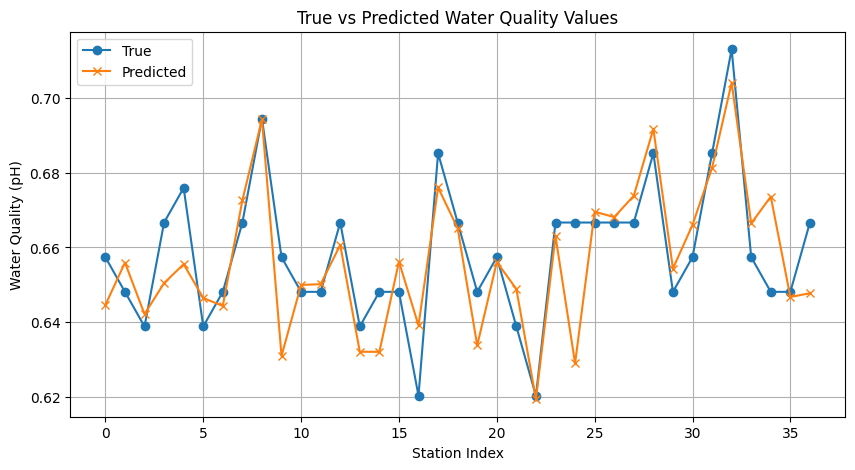

In [216]:

# Visualize predictions after training
visualize_predictions(model, test_loader, device)